# Capstone Project: Exploratory Data Analysis

In [2]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_selection import chi2

In [3]:
# read in data

fashion = pd.read_csv('data/fashion.csv')
fashion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    1136 non-null   object 
 1   Cotton                  1136 non-null   float64
 2   Organic_cotton          1136 non-null   float64
 3   Linen                   1136 non-null   float64
 4   Hemp                    1136 non-null   float64
 5   Jute                    1136 non-null   float64
 6   Other_plant             1136 non-null   float64
 7   Silk                    1136 non-null   float64
 8   Wool                    1136 non-null   float64
 9   Leather                 1136 non-null   float64
 10  Camel                   1136 non-null   float64
 11  Cashmere                1136 non-null   float64
 12  Alpaca                  1136 non-null   float64
 13  Feathers                1136 non-null   float64
 14  Other_animal            1136 non-null   

In [3]:
fashion.columns

Index(['Type', 'Cotton', 'Organic_cotton', 'Linen', 'Hemp', 'Jute',
       'Other_plant', 'Silk', 'Wool', 'Leather', 'Camel', 'Cashmere', 'Alpaca',
       'Feathers', 'Other_animal', 'Polyester', 'Nylon', 'Acrylic', 'Spandex',
       'Polyamide', 'Other_synthetic', 'Lyocell', 'Viscose', 'Acetate',
       'Modal', 'Rayon', 'Other_regenerated', 'Other', 'Recycled_content',
       'Reused_content', 'Material_label', 'Chemicals_label',
       'Production_label', 'Manufacturing_location', 'Transporation_distance',
       'Use_location', 'Washing_instruction', 'Drying_instruction',
       'Reusability_label', 'Recylability_label', 'EI'],
      dtype='object')

In [4]:
# split data for easier eda

raw_material = ['Cotton', 'Organic_cotton', 'Linen', 'Hemp', 'Jute', 'Other_plant', 
           'Silk', 'Wool', 'Leather', 'Camel', 'Cashmere', 'Alpaca','Feathers', 'Other_animal', 
           'Polyester', 'Nylon', 'Acrylic', 'Spandex', 'Polyamide', 'Other_synthetic', 
           'Lyocell', 'Viscose', 'Acetate', 'Modal', 'Rayon', 'Other_regenerated', 'Other',
           'Recycled_content', 'Reused_content']

categoric = ['Type', 'Material_label', 'Chemicals_label', 'Production_label', 'Manufacturing_location',
             'Use_location', 'Washing_instruction', 'Drying_instruction', 'Reusability_label', 'Recylability_label']

### Inspecting balance of classes

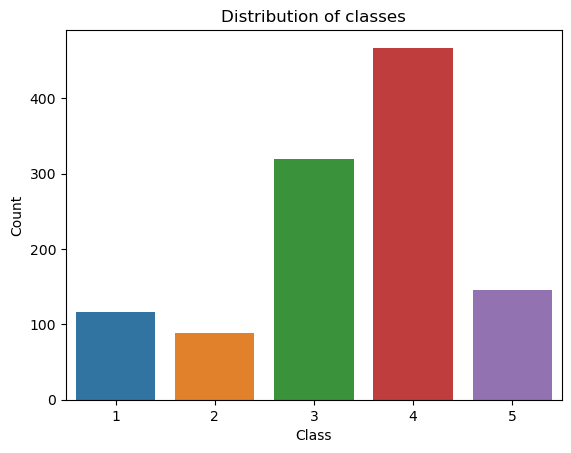

In [4]:
class_dist = pd.DataFrame(fashion['EI'].value_counts().sort_index())

sns.barplot(class_dist, x = class_dist.index, y = 'EI').set(title = 'Distribution of classes');
plt.xlabel('Class')
plt.ylabel('Count');

**Comments:**

The distribution of classes is imbalanced, hence accuracy will not be a good metric to use in the evaluation of the model.

Since we want to minimise the false positives (precision) and false negatives (recall), we will use the F1 score metric (which takes into account both precision and recall) in the evaluation of the model.

In addition, we will use macro-averaging to calculate each metric in the evaluation of the model. This gives each class an equal weightage in the final evaluation, which is important given the imblanaced dataset.


### Inspecting other categorical features

In [6]:
def get_plot(feature):
    df = pd.DataFrame(fashion[feature].value_counts())
    ax = sns.barplot(df, x = df.index, y = feature)
    plt.xlabel(feature)
    plt.ylabel('Count')

    ax.set_title(feature)
    ax.set_xticklabels(labels = df.index, rotation = 90)

    plt.show()

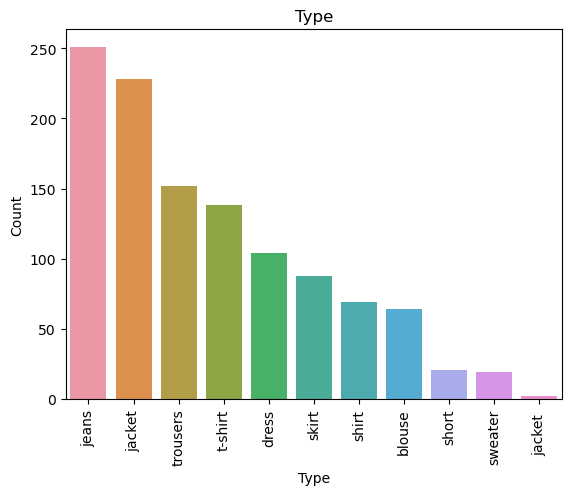

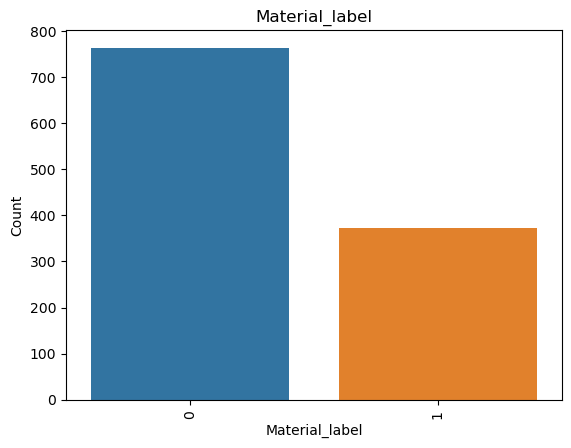

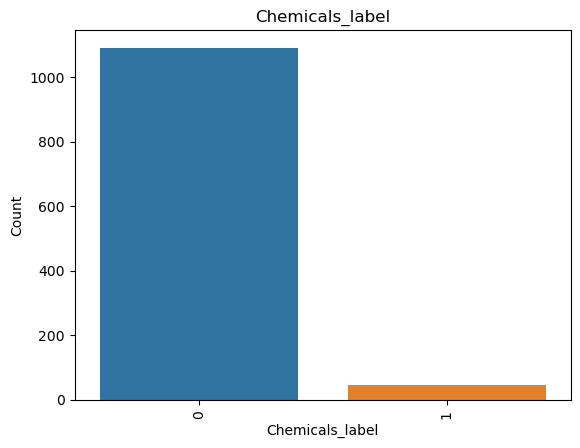

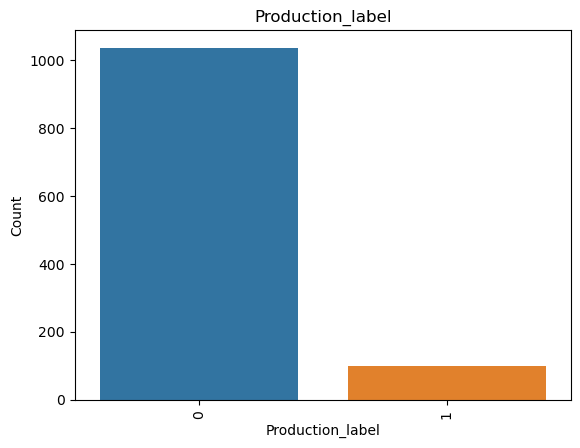

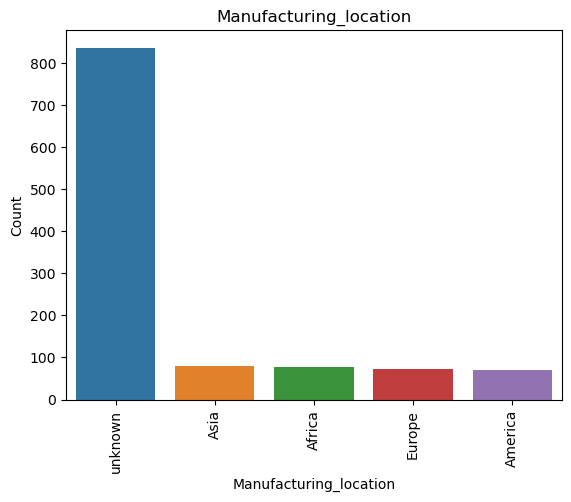

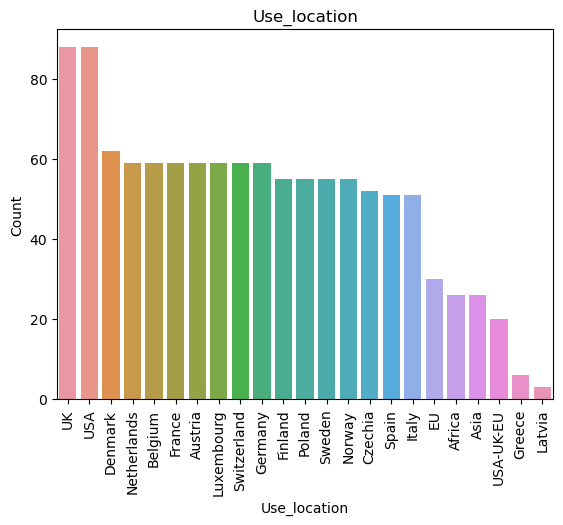

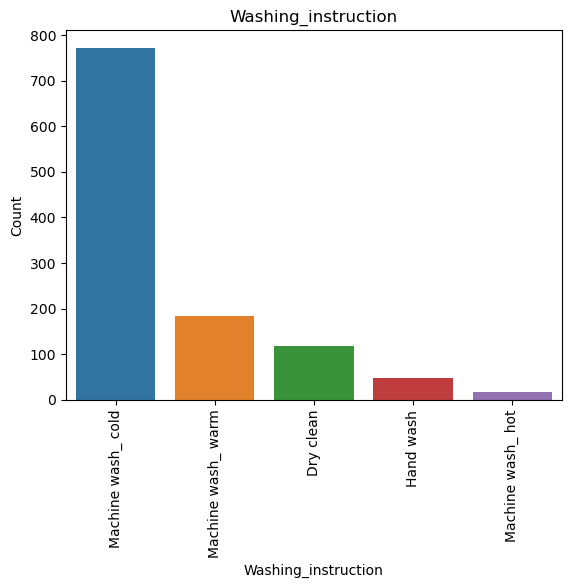

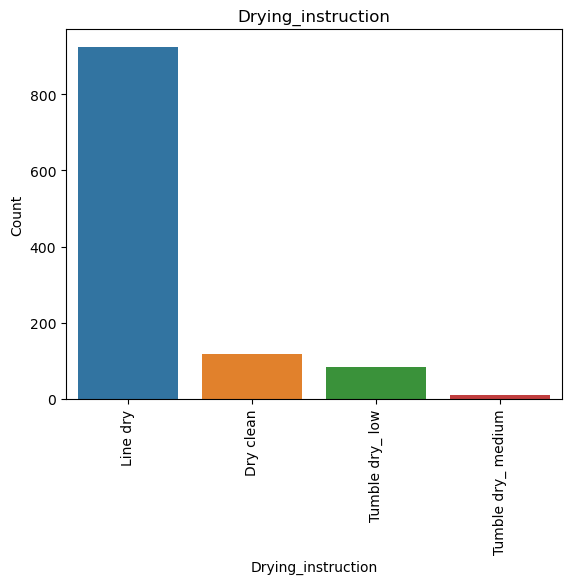

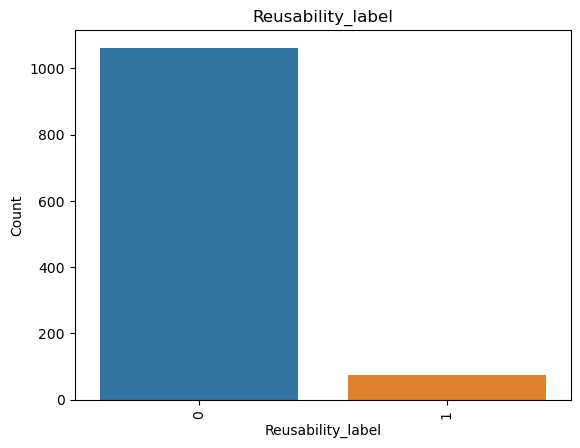

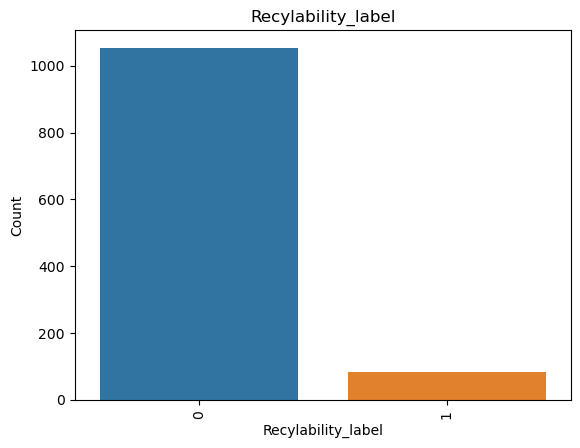

In [7]:
for c in categoric:
    get_plot(c)

**Comments:**

There are two `jacket` values in type. This seems to be due to a typo of adding an extra space behind one of the values. We will correct this.

There also seems to be an imbalance within the independent features. Although this is reflective of imperfect real-world data, we may choose to tune the model by dropping the feature if it is not highly correlated to the target variable. Since these featuers are categorical, we will test for correlation using the chi-square test.

In [8]:
# replace 'jacket ' with 'jacket'
# check

fashion['Type'].replace('jacket ', 'jacket', inplace=True)
fashion['Type'].value_counts()

jeans       251
jacket      230
trousers    152
t-shirt     138
dress       104
skirt        88
shirt        69
blouse       64
short        21
sweater      19
Name: Type, dtype: int64

In [9]:
# conducting the chi2 test

chi_cols = ['Material_label', 'Chemicals_label', 'Production_label', 'Reusability_label', 'Recylability_label']

X = fashion[chi_cols]
y = fashion['EI']

chi_score, p_value = chi2(X,y)

In [10]:
for i, (chi2, p_val) in enumerate(zip(chi_score, p_value)):
    print(f"{chi_cols[i]} p_value: {p_val}")
    if p_val < 0.05:
        print("This feature is statistically significant.")
    else:
        print("This feature is not statistically significant.")

Material_label p_value: 2.6673402647914085e-97
This feature is statistically significant.
Chemicals_label p_value: 5.588558453755987e-16
This feature is statistically significant.
Production_label p_value: 3.708889963526557e-125
This feature is statistically significant.
Reusability_label p_value: 2.464136206834121e-135
This feature is statistically significant.
Recylability_label p_value: 1.6869932018614708e-126
This feature is statistically significant.


**Comments:**

Based on the chi-squared scores, all the features are statistically signficant. We will keep all features.

### Inspecting raw material features

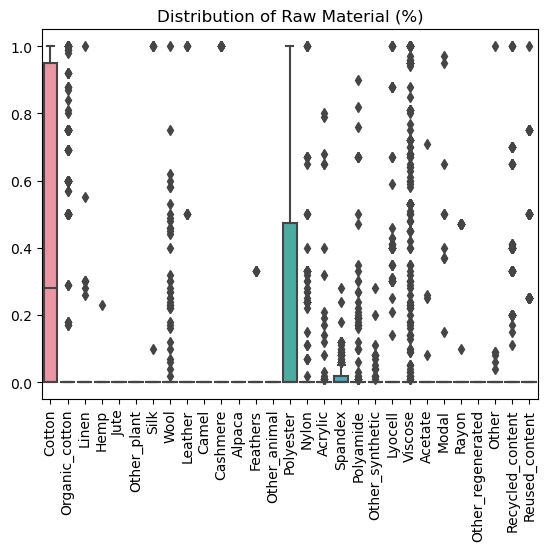

In [11]:
ax = sns.boxplot(fashion[raw_material])
ax.set_title('Distribution of Raw Material (%)')
ax.set_xticklabels(labels = raw_material, rotation = 90);

**Comments:**

The raw material is not normally distributed and has many outliers. This is too be expected as a garment is usually made out of at most four different materials, but the dataset is expected to capture as many different types of materials as possible. We will drop materials that are underrepresented in the dataset to reduce dimensionality, and reduce the outlier effect.

Given the outliers, we will use machine learning models (eg. Random Forest, Support Vector Machines, and k-Nearest Neighbours) that can deal with outliers to train and test our dataset. 

#### Closer inspection of raw material features

In [12]:
# check pct of inputs for a each raw material

for r in raw_material:
    m = (fashion[r] > 0).value_counts(normalize = True).sort_index(ascending=False)
    print(m)
    print()

True     0.556338
False    0.443662
Name: Cotton, dtype: float64

True     0.15669
False    0.84331
Name: Organic_cotton, dtype: float64

True     0.007042
False    0.992958
Name: Linen, dtype: float64

True     0.00088
False    0.99912
Name: Hemp, dtype: float64

False    1.0
Name: Jute, dtype: float64

False    1.0
Name: Other_plant, dtype: float64

True     0.006162
False    0.993838
Name: Silk, dtype: float64

True     0.03257
False    0.96743
Name: Wool, dtype: float64

True     0.008803
False    0.991197
Name: Leather, dtype: float64

False    1.0
Name: Camel, dtype: float64

True     0.012324
False    0.987676
Name: Cashmere, dtype: float64

False    1.0
Name: Alpaca, dtype: float64

True     0.005282
False    0.994718
Name: Feathers, dtype: float64

False    1.0
Name: Other_animal, dtype: float64

True     0.399648
False    0.600352
Name: Polyester, dtype: float64

True     0.048415
False    0.951585
Name: Nylon, dtype: float64

True     0.018486
False    0.981514
Name: Acrylic

**Comments:**

Subsume raw material features that have less than 3% of inputs into the `other_X` catergories, where X is the type of material (plant, animal, synthetic, etc.)

|Feature|Other category|
|-|-|
|Linen|Other_plant|
|Hemp|Other_plant|
|Jute|Other_plant|
|Silk|Other_animal|
|Leather|Other_animal|
|Camel|Other_animal|
|Cashmere|Other_animal|
|Alpaca|Other_animal|
|Feathers|Other_animal|
|Acrylic|Other_synthetic|
|Acetate|Other_regenerated|
|Modal|Other_regenerated|


In [13]:
# subsume material content into the 'other_X' categories

fashion['Other_plant'] = fashion['Linen'] + fashion['Hemp'] + fashion['Jute'] + fashion['Other_plant']
fashion['Other_animal'] = fashion['Silk'] + fashion['Leather'] + fashion['Camel'] + fashion['Cashmere'] + fashion['Alpaca'] + fashion['Feathers'] + fashion['Other_animal']
fashion['Other_synthetic'] = fashion['Acrylic'] + fashion['Other_synthetic']
fashion['Other_regenerated'] = fashion['Acetate'] + fashion['Modal'] + fashion['Other_regenerated']

fashion.drop(columns = ['Linen', 'Hemp', 'Jute', 'Silk', 'Leather', 'Camel', 'Cashmere', 'Alpaca', 'Feathers', 'Acrylic', 'Acetate', 'Modal'], inplace=True)

fashion.shape

(1136, 29)

### Inspecting transportation distance feature

In [14]:
# histogram would not plot with outlier at index 120

pd.options.display.float_format = '{:.0f}'.format
fashion['Transporation_distance'].sort_values(ascending=False)

120    956072727272727
1071             23273
1077             23273
1083             23273
1113             23273
             ...      
1032               100
1038               100
1098               100
1044               100
1092               100
Name: Transporation_distance, Length: 1136, dtype: float64

In [15]:
# drop outlier at index 120 

fashion.drop(index = [120], inplace=True)

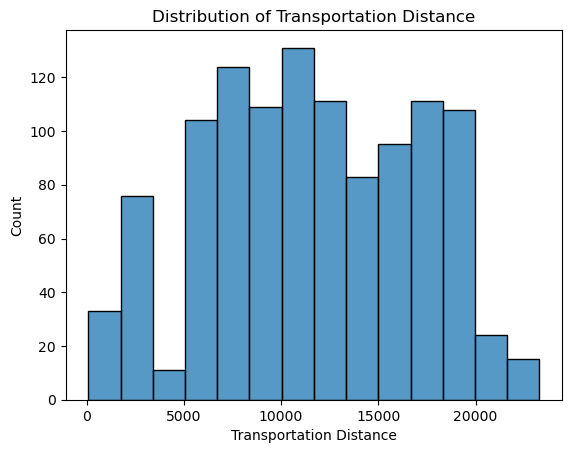

In [16]:
sns.histplot(fashion['Transporation_distance']).set(title = 'Distribution of Transportation Distance')
plt.xlabel('Transportation Distance')
plt.ylabel('Count');

**Comments:**

There was one outlier in the transportation distance that caused the kernel to crash. As the value did not make sense when compared to rows with similar attributes (`manufacturing location` and `use location`), the row was dropped.

Since the distribution is non-normal, a non-parametric model (eg. Random Forest, Support Vector Machines, and k-Nearest Neighbours) would perform better.

### Correlation coefficients

<Axes: >

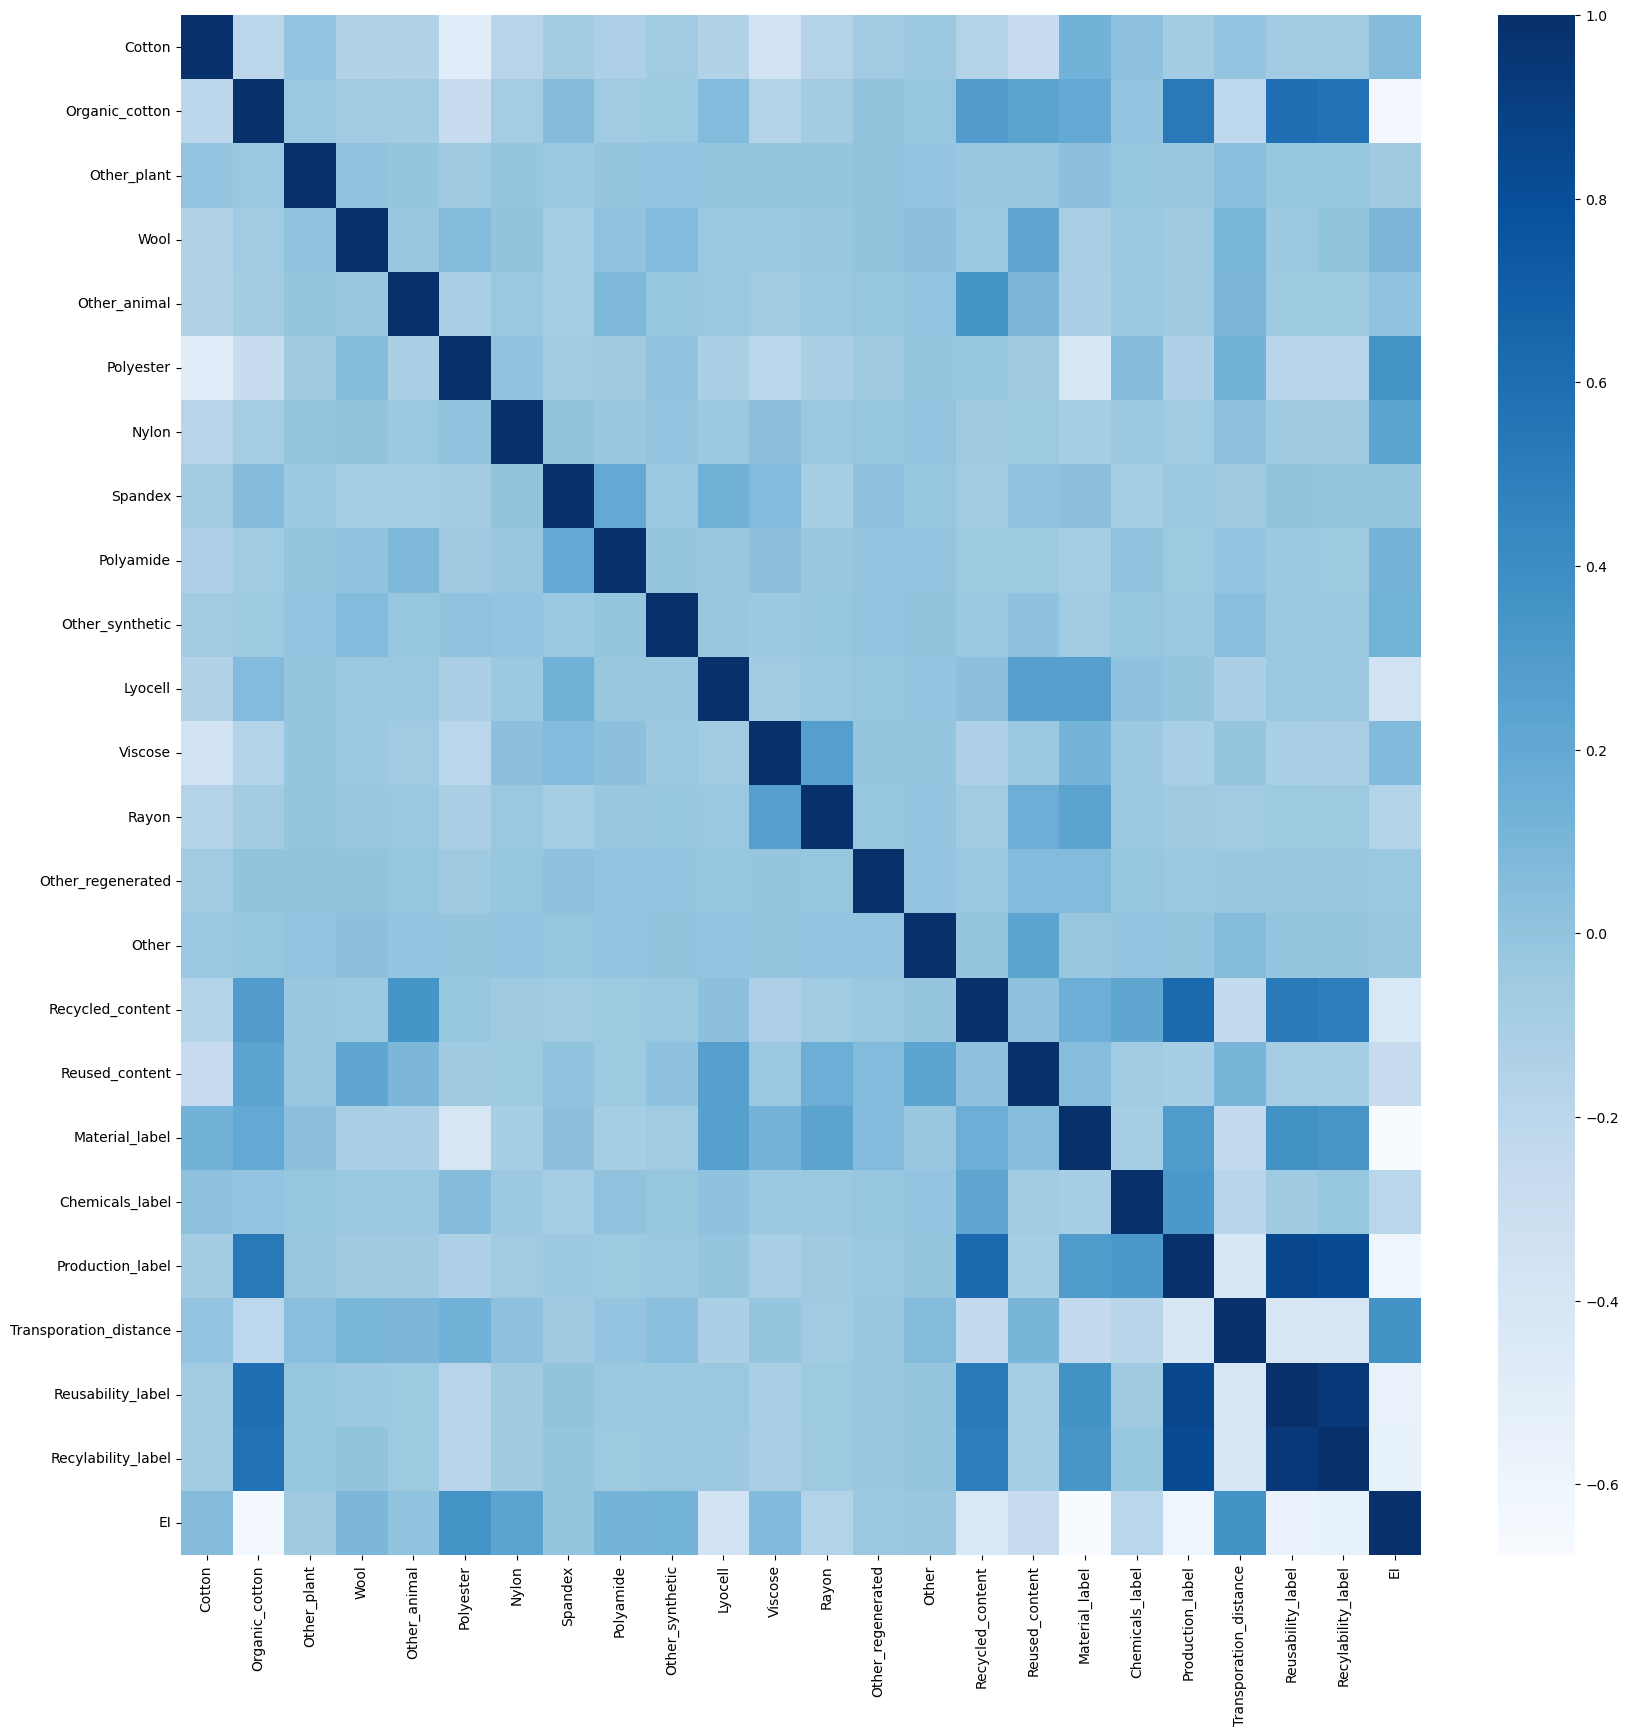

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(fashion.corr(numeric_only=True), cmap='Blues')

**Comments:**

The Pearson correlation shows correlation between a few categorical features (`recylability label`, `reusability label`). However, as these labels are considered statistically signficant based on the chi-square test earlier, we will keep all features.

In [18]:
len(fashion.columns)

29

### Final dataset for modelling

In [19]:
# save modelling dataset

fashion.to_csv('data/for_modelling.csv', index=False)